# End-to-End Workflow: Fine-Tuning Inception V3, Adversarial Attacks, Adversarial Training, and Robustness Evaluation

This comprehensive workflow covers the journey of:
1. **Fine-Tuning Inception V3**: Adapting a pre-trained Inception V3 model for traffic sign classification.
2. **Adversarial Attacks**: Applying various adversarial attacks (FGSM, PGD, BIM) to assess model vulnerability.
3. **Adversarial Training**: Enhancing model robustness through adversarial training.
4. **Robustness Evaluation**: Evaluating the model’s performance against clean and adversarial test data to measure its resilience to attacks.


# Fine-Tuning InceptionV3 on Traffic Signs Dataset

This cell implements a pipeline to classify traffic signs using a pretrained InceptionV3 model. Key steps include:

- **Dataset Preparation**: Downloads, organizes, and splits traffic sign images into train/val sets.
- **Custom Dataset from Kaggle**: Handles image loading and label mapping for 15 traffic sign classes.
- **Model Training**: Fine-tunes InceptionV3 with cross-entropy loss and Adam optimizer, saving the best model.
- **Evaluation**: Tracks training/validation loss and accuracy, with GPU support for faster execution.


In [1]:
import os
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from pathlib import Path
import shutil
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import kagglehub
import matplotlib.pyplot as plt
from PIL import Image

# Install required packages
# !pip install kagglehub torch torchvision matplotlib tqdm pillow

class TrafficSignDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

        # Class mapping
        self.class_names = [
            'Green Light', 'Red Light', 'Speed Limit 10', 'Speed Limit 20',
            'Speed Limit 30', 'Speed Limit 40', 'Speed Limit 50', 'Speed Limit 60',
            'Speed Limit 70', 'Speed Limit 80', 'Speed Limit 90', 'Speed Limit 100',
            'Speed Limit 110', 'Speed Limit 120', 'Stop'
        ]
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.class_names)}

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')

        # Get label from the parent directory name
        label = img_path.parent.name
        label_idx = self.class_to_idx[label]

        if self.transform:
            image = self.transform(image)

        return image, label_idx

def organize_dataset(base_path="/root/.cache/kagglehub/datasets/pkdarabi/cardetection/versions/5"):
    # Download dataset
    path = kagglehub.dataset_download("pkdarabi/cardetection")
    print("Dataset downloaded to:", path)

    base_path = Path(base_path)
    output_path = Path("classification_dataset")

    # Create directories for each class
    for split in ['train', 'val']:
        (output_path / split).mkdir(parents=True, exist_ok=True)
        for class_name in ['Green Light', 'Red Light', 'Speed Limit 10', 'Speed Limit 20',
                          'Speed Limit 30', 'Speed Limit 40', 'Speed Limit 50', 'Speed Limit 60',
                          'Speed Limit 70', 'Speed Limit 80', 'Speed Limit 90', 'Speed Limit 100',
                          'Speed Limit 110', 'Speed Limit 120', 'Stop']:
            (output_path / split / class_name).mkdir(parents=True, exist_ok=True)

    # Process images and labels
    images = list((base_path / "car/train/images").glob("*.jpg"))
    labels_dir = base_path / "car/train/labels"

    def get_class_from_label(label_path):
        with open(label_path, 'r') as f:
            first_line = f.readline().strip()
            if first_line:
                class_idx = int(first_line.split()[0])
                class_names = ['Green Light', 'Red Light', 'Speed Limit 10', 'Speed Limit 20',
                             'Speed Limit 30', 'Speed Limit 40', 'Speed Limit 50', 'Speed Limit 60',
                             'Speed Limit 70', 'Speed Limit 80', 'Speed Limit 90', 'Speed Limit 100',
                             'Speed Limit 110', 'Speed Limit 120', 'Stop']
                return class_names[class_idx]
        return None

    # Split dataset
    train_imgs, val_imgs = train_test_split(images, test_size=0.2, random_state=42)

    def process_images(image_list, split):
        for img in image_list:
            label_path = labels_dir / f"{img.stem}.txt"
            if label_path.exists():
                class_name = get_class_from_label(label_path)
                if class_name:
                    shutil.copy(img, output_path / split / class_name / img.name)

    process_images(train_imgs, "train")
    process_images(val_imgs, "val")

    return output_path

def train_inception():
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Data transformations
    transform = transforms.Compose([
        transforms.Resize((299, 299)),  # InceptionV3 requires 299x299 input
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Prepare datasets
    dataset_path = organize_dataset()
    train_dataset = TrafficSignDataset(
        list(Path(dataset_path / "train").rglob("*.jpg")),
        transform=transform
    )
    val_dataset = TrafficSignDataset(
        list(Path(dataset_path / "val").rglob("*.jpg")),
        transform=transform
    )

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

    # Initialize model
    model = models.inception_v3(pretrained=True)
    model.aux_logits = False  # Disable auxiliary output
    model.fc = nn.Linear(model.fc.in_features, 15)  # 15 classes
    model = model.to(device)

    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3)

    # Training loop
    num_epochs = 10
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0

        with tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}') as pbar:
            for images, labels in pbar:
                images, labels = images.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                total_train_loss += loss.item()
                pbar.set_postfix({'loss': loss.item()})

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        total_val_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                total_val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        accuracy = 100 * correct / total

        print(f'Epoch {epoch+1}:')
        print(f'Training Loss: {avg_train_loss:.4f}')
        print(f'Validation Loss: {avg_val_loss:.4f}')
        print(f'Validation Accuracy: {accuracy:.2f}%')

        # Learning rate scheduling
        scheduler.step(avg_val_loss)

        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_model.pth')

    # Plot training curves
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('training_curves.png')
    plt.close()

if __name__ == "__main__":
    train_inception()

Using device: cuda


100%|██████████| 99.8M/99.8M [00:05<00:00, 19.1MB/s]

Extracting files...


Dataset downloaded to: /root/.cache/kagglehub/datasets/pkdarabi/cardetection/versions/5


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=I

Epoch 1:
Training Loss: 1.6237
Validation Loss: 1.5978
Validation Accuracy: 51.70%


Epoch 2/10: 100%|██████████| 89/89 [00:41<00:00,  2.13it/s, loss=0.674]


Epoch 2:
Training Loss: 0.9791
Validation Loss: 1.4057
Validation Accuracy: 67.28%


Epoch 3/10: 100%|██████████| 89/89 [00:40<00:00,  2.19it/s, loss=1.24]


Epoch 3:
Training Loss: 0.7697
Validation Loss: 0.6649
Validation Accuracy: 79.32%


Epoch 4/10: 100%|██████████| 89/89 [00:40<00:00,  2.17it/s, loss=0.257]


Epoch 4:
Training Loss: 0.6132
Validation Loss: 0.9558
Validation Accuracy: 74.79%


Epoch 5/10: 100%|██████████| 89/89 [00:40<00:00,  2.18it/s, loss=0.622]


Epoch 5:
Training Loss: 0.5543
Validation Loss: 0.8821
Validation Accuracy: 72.52%


Epoch 6/10: 100%|██████████| 89/89 [00:40<00:00,  2.18it/s, loss=0.0959]


Epoch 6:
Training Loss: 0.5030
Validation Loss: 0.9711
Validation Accuracy: 73.09%


Epoch 7/10: 100%|██████████| 89/89 [00:40<00:00,  2.18it/s, loss=0.433]


Epoch 7:
Training Loss: 0.3721
Validation Loss: 0.4811
Validation Accuracy: 85.69%


Epoch 8/10: 100%|██████████| 89/89 [00:40<00:00,  2.19it/s, loss=1.49]


Epoch 8:
Training Loss: 0.3256
Validation Loss: 0.7455
Validation Accuracy: 79.46%


Epoch 9/10: 100%|██████████| 89/89 [00:40<00:00,  2.19it/s, loss=0.563]


Epoch 9:
Training Loss: 0.3709
Validation Loss: 0.5848
Validation Accuracy: 84.56%


Epoch 10/10: 100%|██████████| 89/89 [00:40<00:00,  2.19it/s, loss=1.4]


Epoch 10:
Training Loss: 0.3481
Validation Loss: 0.5896
Validation Accuracy: 84.42%


# Adversarial Attack Evaluation

This code evaluates three adversarial attacks on a pretrained traffic sign classification model:

- **Attack Methods**:
  - **FGSM**: Fast Gradient Sign Method
  - **PGD**: Projected Gradient Descent
  - **BIM**: Basic Iterative Method

- **Execution**: Generates perturbed images and computes the attack success rate by comparing original vs adversarial predictions.

- **Evaluation**: Displays success rates, visualizes original and adversarial images, and analyzes perturbation magnitude and heatmaps.

Provides insights into the model's vulnerability to adversarial attacks.


Using device: cuda


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-5-8230632b3149>:165: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for mo

Successfully loaded model weights
Test dataset size: 706

Running FGSM attack...
FGSM Attack Success Rate: 40.00%


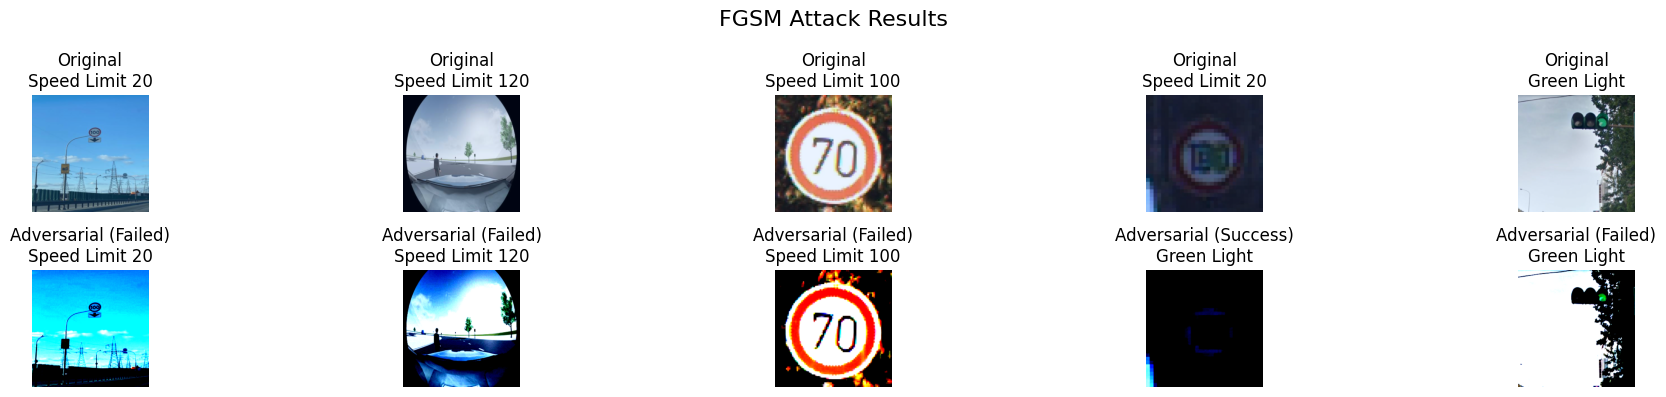


Running PGD attack...
PGD Attack Success Rate: 70.00%


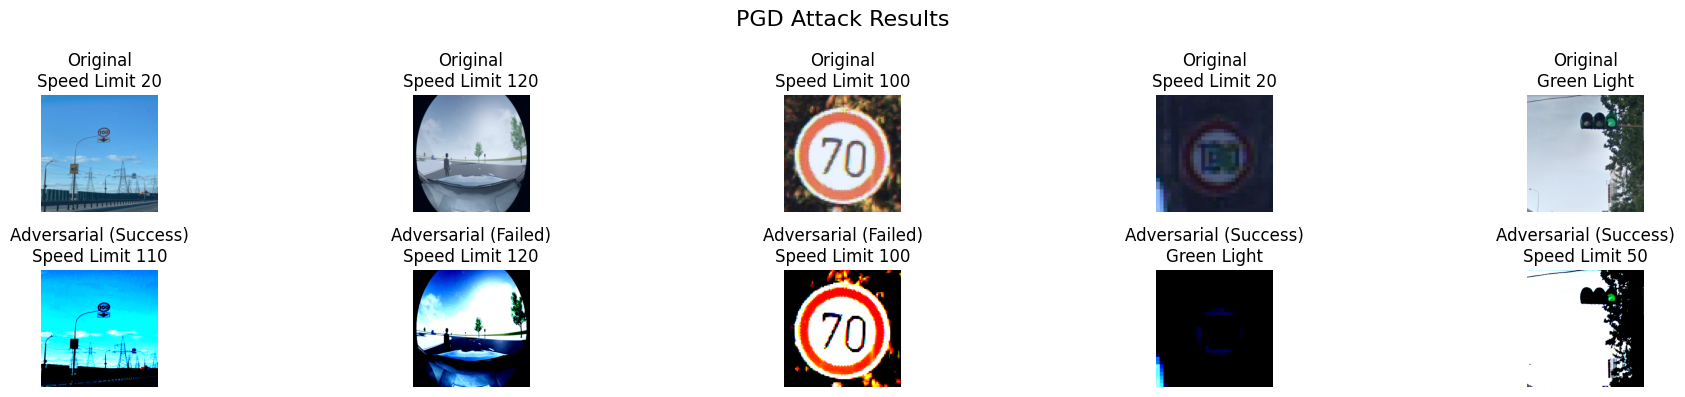


Running BIM attack...
BIM Attack Success Rate: 70.00%


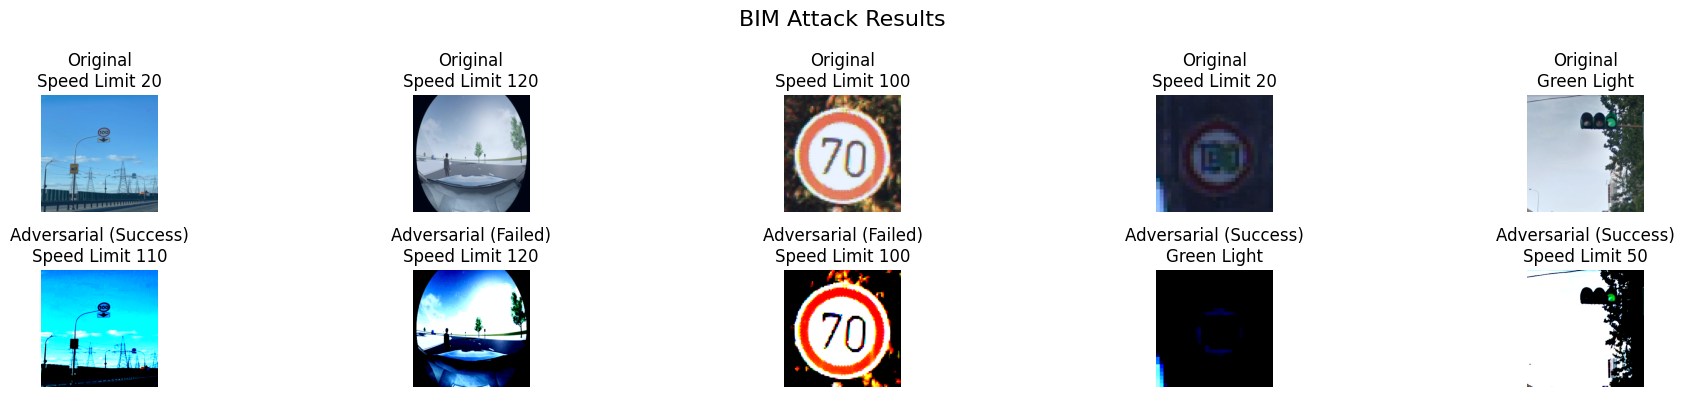


Analyzing FGSM perturbations:
Average Perturbation Magnitude: 1.2126
Max Perturbation Magnitude: 3.1179


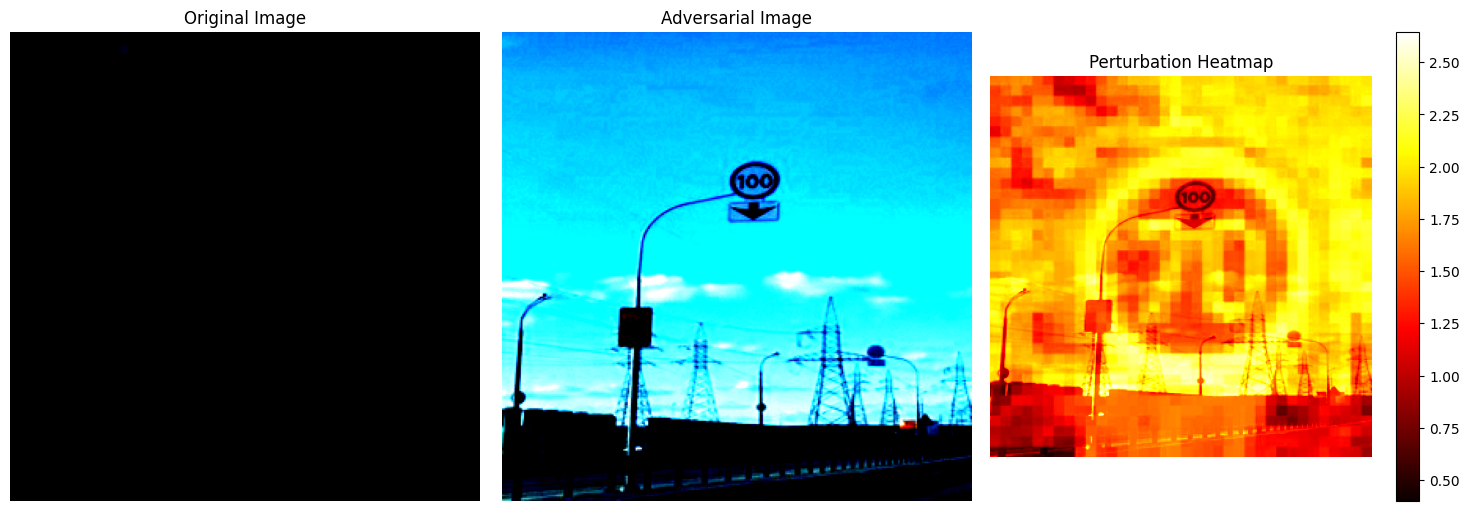


Analyzing PGD perturbations:
Average Perturbation Magnitude: 1.1213
Max Perturbation Magnitude: 3.1179


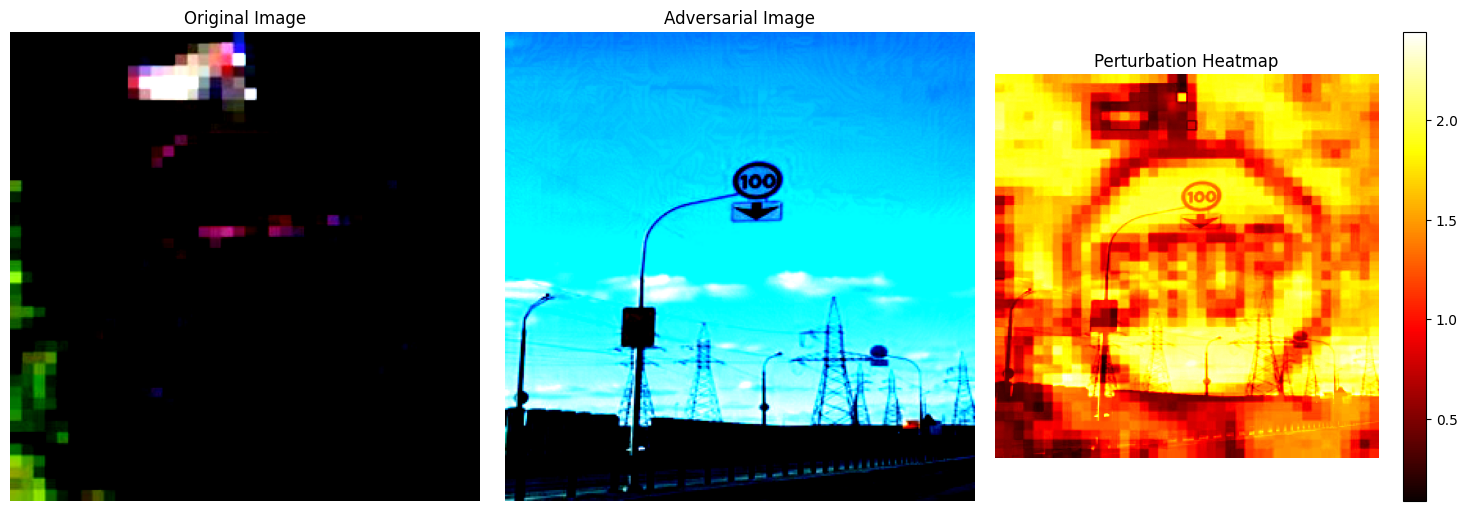


Analyzing BIM perturbations:
Average Perturbation Magnitude: 1.1372
Max Perturbation Magnitude: 3.1179


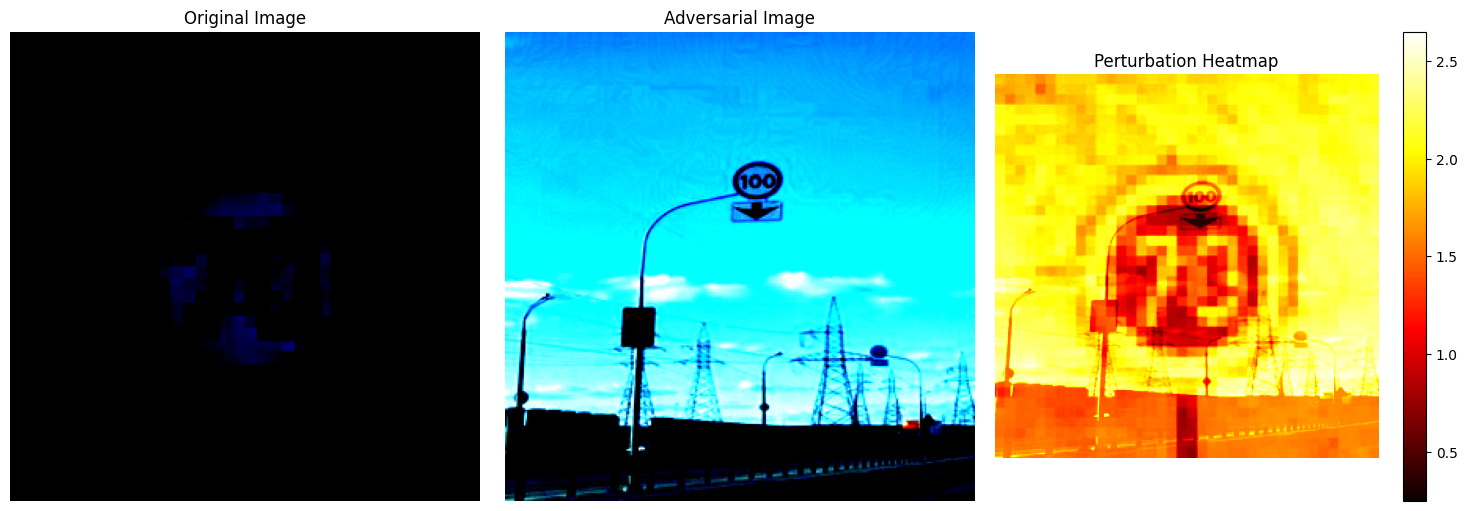

In [5]:
import torch.nn.functional as F
import numpy as np

class AdversarialAttacks:
    def __init__(self, model, device):
        self.model = model
        self.device = device
        self.model.eval()

    def fgsm_attack(self, images, labels, eps=0.02):
        images = images.clone().detach()
        images.requires_grad = True

        outputs = self.model(images)
        loss = F.cross_entropy(outputs, labels)
        loss.backward()

        grad_sign = images.grad.data.sign()
        perturbed_images = images + eps * grad_sign
        perturbed_images = torch.clamp(perturbed_images, 0, 1)

        return perturbed_images.detach()  # Detach here

    def pgd_attack(self, images, labels, eps=0.02, alpha=0.01, iters=10):
        perturbed_images = images.clone().detach()
        perturbed_images = perturbed_images + torch.empty_like(perturbed_images).uniform_(-eps, eps)
        perturbed_images = torch.clamp(perturbed_images, 0, 1)

        for i in range(iters):
            perturbed_images.requires_grad = True
            outputs = self.model(perturbed_images)
            loss = F.cross_entropy(outputs, labels)
            loss.backward()

            with torch.no_grad():
                grad_sign = perturbed_images.grad.data.sign()
                perturbed_images = perturbed_images + alpha * grad_sign
                eta = torch.clamp(perturbed_images - images, -eps, eps)
                perturbed_images = torch.clamp(images + eta, 0, 1)

        return perturbed_images.detach()  # Detach here

    def bim_attack(self, images, labels, eps=0.02, alpha=0.01, iters=10):
        perturbed_images = images.clone().detach()

        for i in range(iters):
            perturbed_images.requires_grad = True
            outputs = self.model(perturbed_images)
            loss = F.cross_entropy(outputs, labels)
            loss.backward()

            with torch.no_grad():
                grad_sign = perturbed_images.grad.data.sign()
                perturbed_images = perturbed_images + alpha * grad_sign
                perturbed_images = torch.clamp(perturbed_images, images - eps, images + eps)
                perturbed_images = torch.clamp(perturbed_images, 0, 1)

        return perturbed_images.detach()  # Detach here

def evaluate_attacks(model, test_loader, device, class_names):
    model.eval()
    attacks = AdversarialAttacks(model, device)

    images, labels = next(iter(test_loader))
    images, labels = images.to(device), labels.to(device)

    results = {}
    attack_params = {
        'FGSM': {'eps': 0.02},
        'PGD': {'eps': 0.02, 'alpha': 0.01, 'iters': 10},
        'BIM': {'eps': 0.02, 'alpha': 0.01, 'iters': 10}
    }

    for attack_name, params in attack_params.items():
        print(f"\nRunning {attack_name} attack...")

        if attack_name == 'FGSM':
            perturbed_images = attacks.fgsm_attack(images, labels, **params)
        elif attack_name == 'PGD':
            perturbed_images = attacks.pgd_attack(images, labels, **params)
        elif attack_name == 'BIM':
            perturbed_images = attacks.bim_attack(images, labels, **params)

        with torch.no_grad():
            orig_outputs = model(images)
            adv_outputs = model(perturbed_images)

        orig_preds = torch.argmax(orig_outputs, dim=1)
        adv_preds = torch.argmax(adv_outputs, dim=1)

        success_rate = (orig_preds != adv_preds).float().mean().item()
        print(f"{attack_name} Attack Success Rate: {success_rate*100:.2f}%")

        results[attack_name] = {
            'perturbed_images': perturbed_images.cpu().detach(),  # Detach here
            'orig_preds': orig_preds.cpu(),
            'adv_preds': adv_preds.cpu(),
            'success_rate': success_rate
        }

        # Visualization
        n_images = 5
        plt.figure(figsize=(20, 4))
        for i in range(n_images):
            # Original image
            plt.subplot(2, n_images, i + 1)
            img = images[i].cpu().detach().permute(1, 2, 0).numpy()
            img = (img - img.min()) / (img.max() - img.min())
            plt.imshow(img)
            plt.axis('off')
            plt.title(f'Original\n{class_names[orig_preds[i]]}')

            # Adversarial image
            plt.subplot(2, n_images, i + n_images + 1)
            adv_img = perturbed_images[i].cpu().detach().permute(1, 2, 0).numpy()
            adv_img = (adv_img - adv_img.min()) / (adv_img.max() - adv_img.min())
            plt.imshow(adv_img)
            plt.axis('off')
            success = "Success" if orig_preds[i] != adv_preds[i] else "Failed"
            plt.title(f'Adversarial ({success})\n{class_names[adv_preds[i]]}')

        plt.suptitle(f'{attack_name} Attack Results', fontsize=16)
        plt.tight_layout()
        plt.show()

    return results

def analyze_perturbations(images, perturbed_images):
    perturbation = (perturbed_images - images).abs()

    print(f"Average Perturbation Magnitude: {perturbation.mean():.4f}")
    print(f"Max Perturbation Magnitude: {perturbation.max():.4f}")

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(images[0].cpu().detach().permute(1, 2, 0).numpy())  # Detach here
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(perturbed_images[0].cpu().detach().permute(1, 2, 0).numpy())  # Detach here
    plt.title('Adversarial Image')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    perturbation_map = perturbation[0].cpu().detach().mean(dim=0).numpy()  # Detach here
    plt.imshow(perturbation_map, cmap='hot')
    plt.title('Perturbation Heatmap')
    plt.colorbar()
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Main execution code remains the same...
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    model = models.inception_v3(pretrained=True)
    model.aux_logits = False
    model.fc = nn.Linear(model.fc.in_features, 15)

    try:
        model.load_state_dict(torch.load('best_model.pth'))
        print("Successfully loaded model weights")
    except:
        print("Error: Could not find best_model.pth. Please make sure you've trained the model first.")
        exit()

    model = model.to(device)
    model.eval()

    test_transform = transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    dataset_path = Path("classification_dataset")
    if not dataset_path.exists():
        print("Error: Dataset not found. Please run the training code first.")
        exit()

    try:
        test_dataset = TrafficSignDataset(
            list(Path(dataset_path / "val").rglob("*.jpg")),
            transform=test_transform
        )
        test_loader = DataLoader(test_dataset, batch_size=10, shuffle=True)
        print(f"Test dataset size: {len(test_dataset)}")
    except Exception as e:
        print(f"Error initializing dataset: {e}")
        exit()

    try:
        results = evaluate_attacks(model, test_loader, device, test_dataset.class_names)

        for attack_name, attack_results in results.items():
            print(f"\nAnalyzing {attack_name} perturbations:")
            images, _ = next(iter(test_loader))
            images = images.to(device)
            analyze_perturbations(images, attack_results['perturbed_images'].to(device))
    except Exception as e:
        print(f"Error during attack evaluation: {e}")

# Adversarial Training and Robustness Evaluation

This code demonstrates adversarial training and robustness evaluation for a traffic sign classification model using PyTorch. Key components include:

- **Custom Dataset**: Loads and processes traffic sign images, mapping them to 15 classes.
- **Adversarial Attacks**: Implements three attacks—FGSM, PGD, and BIM—to generate adversarial examples.
- **Adversarial Training**: Fine-tunes the model using a combination of clean and adversarial images, improving robustness.
- **Evaluation**: Measures the model's accuracy on clean and adversarially perturbed images.

The notebook leverages these techniques to improve model performance against adversarial attacks and assess its resilience.

Using device: cuda


<ipython-input-3-3eeb5ada7733>:223: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Successfully loaded model weights
Train dataset size: 2821
Test dataset size: 706
Starting adversarial training...


Epoch 1/10: 100%|██████████| 177/177 [05:23<00:00,  1.83s/it, loss=0.0177, acc=73.6]


Epoch 1:
Average Loss: 0.0177
Training Accuracy: 73.60%


Epoch 2/10: 100%|██████████| 177/177 [05:23<00:00,  1.83s/it, loss=0.0113, acc=81.3]


Epoch 2:
Average Loss: 0.0113
Training Accuracy: 81.28%


Epoch 3/10: 100%|██████████| 177/177 [05:23<00:00,  1.83s/it, loss=0.00887, acc=85.1]


Epoch 3:
Average Loss: 0.0089
Training Accuracy: 85.05%


Epoch 4/10: 100%|██████████| 177/177 [05:23<00:00,  1.83s/it, loss=0.00787, acc=86.8]


Epoch 4:
Average Loss: 0.0079
Training Accuracy: 86.75%


Epoch 5/10: 100%|██████████| 177/177 [05:24<00:00,  1.83s/it, loss=0.007, acc=87.4]


Epoch 5:
Average Loss: 0.0070
Training Accuracy: 87.37%


Epoch 6/10: 100%|██████████| 177/177 [05:23<00:00,  1.83s/it, loss=0.00611, acc=88.6]


Epoch 6:
Average Loss: 0.0061
Training Accuracy: 88.59%


Epoch 7/10: 100%|██████████| 177/177 [05:23<00:00,  1.83s/it, loss=0.00552, acc=89.5]


Epoch 7:
Average Loss: 0.0055
Training Accuracy: 89.50%


Epoch 8/10: 100%|██████████| 177/177 [05:23<00:00,  1.83s/it, loss=0.00505, acc=90.5]


Epoch 8:
Average Loss: 0.0050
Training Accuracy: 90.52%


Epoch 9/10: 100%|██████████| 177/177 [05:23<00:00,  1.83s/it, loss=0.00514, acc=90.4]


Epoch 9:
Average Loss: 0.0051
Training Accuracy: 90.42%


Epoch 10/10: 100%|██████████| 177/177 [05:23<00:00,  1.83s/it, loss=0.00447, acc=91.6]


Epoch 10:
Average Loss: 0.0045
Training Accuracy: 91.55%


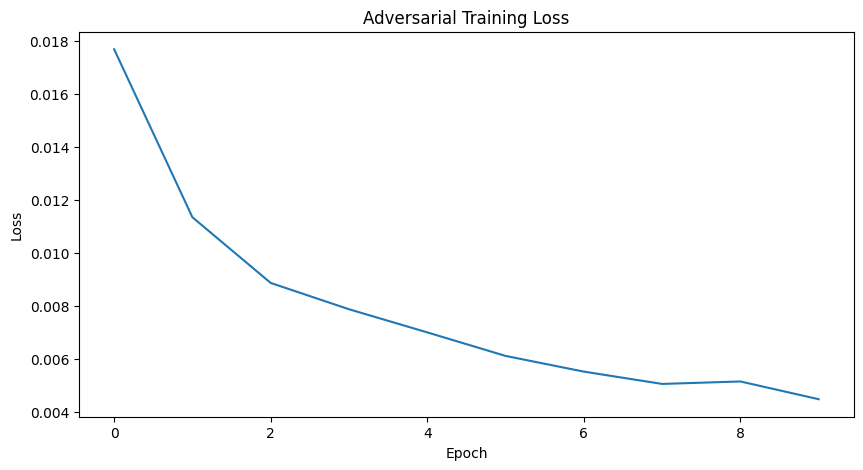


Evaluating model robustness...

Clean Test Accuracy: 90.65%

Testing against FGSM...
FGSM Test Accuracy: 82.58%

Testing against PGD...
PGD Test Accuracy: 75.92%

Testing against BIM...
BIM Test Accuracy: 75.92%

Loading original model for comparison...


<ipython-input-3-3eeb5ada7733>:293: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  original_model.load_state_dict(torch.load('best_model.pth'))



Clean Test Accuracy: 85.69%

Testing against FGSM...
FGSM Test Accuracy: 56.66%

Testing against PGD...
PGD Test Accuracy: 30.59%

Testing against BIM...
BIM Test Accuracy: 30.88%


In [3]:

class TrafficSignDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

        self.class_names = [
            'Green Light', 'Red Light', 'Speed Limit 10', 'Speed Limit 20',
            'Speed Limit 30', 'Speed Limit 40', 'Speed Limit 50', 'Speed Limit 60',
            'Speed Limit 70', 'Speed Limit 80', 'Speed Limit 90', 'Speed Limit 100',
            'Speed Limit 110', 'Speed Limit 120', 'Stop'
        ]
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.class_names)}

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = img_path.parent.name
        label_idx = self.class_to_idx[label]

        if self.transform:
            image = self.transform(image)

        return image, label_idx

class AdversarialAttacks:
    def __init__(self, model, device):
        self.model = model
        self.device = device
        self.model.eval()

    def fgsm_attack(self, images, labels, eps=0.02):
        images = images.clone().detach()
        images.requires_grad = True

        outputs = self.model(images)
        loss = F.cross_entropy(outputs, labels)
        loss.backward()

        grad_sign = images.grad.data.sign()
        perturbed_images = images + eps * grad_sign
        perturbed_images = torch.clamp(perturbed_images, 0, 1)

        return perturbed_images.detach()

    def pgd_attack(self, images, labels, eps=0.02, alpha=0.01, iters=10):
        perturbed_images = images.clone().detach()
        perturbed_images = perturbed_images + torch.empty_like(perturbed_images).uniform_(-eps, eps)
        perturbed_images = torch.clamp(perturbed_images, 0, 1)

        for i in range(iters):
            perturbed_images.requires_grad = True
            outputs = self.model(perturbed_images)
            loss = F.cross_entropy(outputs, labels)
            loss.backward()

            with torch.no_grad():
                grad_sign = perturbed_images.grad.data.sign()
                perturbed_images = perturbed_images + alpha * grad_sign
                eta = torch.clamp(perturbed_images - images, -eps, eps)
                perturbed_images = torch.clamp(images + eta, 0, 1)

        return perturbed_images.detach()

    def bim_attack(self, images, labels, eps=0.02, alpha=0.01, iters=10):
        perturbed_images = images.clone().detach()

        for i in range(iters):
            perturbed_images.requires_grad = True
            outputs = self.model(perturbed_images)
            loss = F.cross_entropy(outputs, labels)
            loss.backward()

            with torch.no_grad():
                grad_sign = perturbed_images.grad.data.sign()
                perturbed_images = perturbed_images + alpha * grad_sign
                perturbed_images = torch.clamp(perturbed_images, images - eps, images + eps)
                perturbed_images = torch.clamp(perturbed_images, 0, 1)

        return perturbed_images.detach()

def adversarial_train(model, train_loader, optimizer, device, num_epochs=10):
    """
    Train model with adversarial training using multiple attack types
    """
    model.train()
    attacks = AdversarialAttacks(model, device)
    train_losses = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        total_correct = 0
        total_samples = 0

        with tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}') as pbar:
            for images, labels in pbar:
                images, labels = images.to(device), labels.to(device)
                batch_size = images.size(0)

                # Generate adversarial examples using different attacks
                fgsm_images = attacks.fgsm_attack(images, labels, eps=0.02)
                pgd_images = attacks.pgd_attack(images, labels, eps=0.02, alpha=0.01, iters=5)

                # Combine clean and adversarial images
                combined_images = torch.cat([images, fgsm_images, pgd_images])
                combined_labels = torch.cat([labels, labels, labels])

                # Training step
                optimizer.zero_grad()
                outputs = model(combined_images)
                loss = F.cross_entropy(outputs, combined_labels)
                loss.backward()
                optimizer.step()

                # Track metrics
                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_correct += (predicted == combined_labels).sum().item()
                total_samples += combined_labels.size(0)

                # Update progress bar
                pbar.set_postfix({
                    'loss': running_loss/total_samples,
                    'acc': 100.*total_correct/total_samples
                })

        epoch_loss = running_loss/total_samples
        epoch_acc = 100.*total_correct/total_samples
        train_losses.append(epoch_loss)

        print(f'Epoch {epoch+1}:')
        print(f'Average Loss: {epoch_loss:.4f}')
        print(f'Training Accuracy: {epoch_acc:.2f}%')

    return train_losses

def evaluate_robustness(model, test_loader, device, class_names):
    """
    Evaluate model robustness against different attacks
    """
    model.eval()
    attacks = AdversarialAttacks(model, device)

    results = {}
    attack_configs = {
        'FGSM': {'eps': 0.02},
        'PGD': {'eps': 0.02, 'alpha': 0.01, 'iters': 10},
        'BIM': {'eps': 0.02, 'alpha': 0.01, 'iters': 10}
    }

    # Test clean accuracy
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    clean_acc = 100 * correct / total
    print(f"\nClean Test Accuracy: {clean_acc:.2f}%")

    # Test against each attack
    for attack_name, params in attack_configs.items():
        print(f"\nTesting against {attack_name}...")
        correct = 0
        total = 0

        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            if attack_name == 'FGSM':
                perturbed_images = attacks.fgsm_attack(images, labels, **params)
            elif attack_name == 'PGD':
                perturbed_images = attacks.pgd_attack(images, labels, **params)
            else:  # BIM
                perturbed_images = attacks.bim_attack(images, labels, **params)

            with torch.no_grad():
                outputs = model(perturbed_images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        adv_acc = 100 * correct / total
        print(f"{attack_name} Test Accuracy: {adv_acc:.2f}%")
        results[attack_name] = adv_acc

    return clean_acc, results

if __name__ == "__main__":
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Initialize model
    model = models.inception_v3(pretrained=True)
    model.aux_logits = False
    model.fc = nn.Linear(model.fc.in_features, 15)

    # Load your trained model
    try:
        model.load_state_dict(torch.load('best_model.pth'))
        print("Successfully loaded model weights")
    except:
        print("Error: Could not find best_model.pth. Please make sure you've trained the model first.")
        exit()

    model = model.to(device)

    # Define transforms
    transform = transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Get dataset path
    dataset_path = Path("classification_dataset")
    if not dataset_path.exists():
        print("Error: Dataset not found. Please run the training code first.")
        exit()

    # Initialize datasets
    try:
        train_dataset = TrafficSignDataset(
            list(Path(dataset_path / "train").rglob("*.jpg")),
            transform=transform
        )
        test_dataset = TrafficSignDataset(
            list(Path(dataset_path / "val").rglob("*.jpg")),
            transform=transform
        )

        # Create data loaders
        train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
        test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)

        print(f"Train dataset size: {len(train_dataset)}")
        print(f"Test dataset size: {len(test_dataset)}")
    except Exception as e:
        print(f"Error initializing dataset: {e}")
        exit()

    print("Starting adversarial training...")

    # Create optimizer for adversarial training
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

    # Perform adversarial training
    train_losses = adversarial_train(model, train_loader, optimizer, device)

    # Save adversarially trained model
    torch.save(model.state_dict(), 'adversarial_model.pth')

    # Plot training losses
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses)
    plt.title('Adversarial Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

    # Evaluate robustness
    print("\nEvaluating model robustness...")
    clean_acc, attack_results = evaluate_robustness(model, test_loader, device, test_dataset.class_names)

    # Compare with original model
    print("\nLoading original model for comparison...")
    original_model = models.inception_v3(pretrained=True)
    original_model.aux_logits = False
    original_model.fc = nn.Linear(original_model.fc.in_features, 15)
    original_model.load_state_dict(torch.load('best_model.pth'))
    original_model = original_model.to(device)
    original_clean_acc, original_attack_results = evaluate_robustness(
        original_model, test_loader, device, test_dataset.class_names
    )


# Model Robustness Comparison

This code visualizes the robustness of the original model and the adversarially trained model by comparing their performance on clean and adversarial examples. Key points include:

- **Attack Types**: The comparison covers multiple attack methods, including FGSM, PGD, and BIM.
- **Accuracy Plot**: The plot displays the accuracy of both models under clean and perturbed conditions.
- **Bar Chart**: A side-by-side bar chart compares the accuracy of the original model and the adversarially trained model, highlighting their resilience to adversarial attacks.


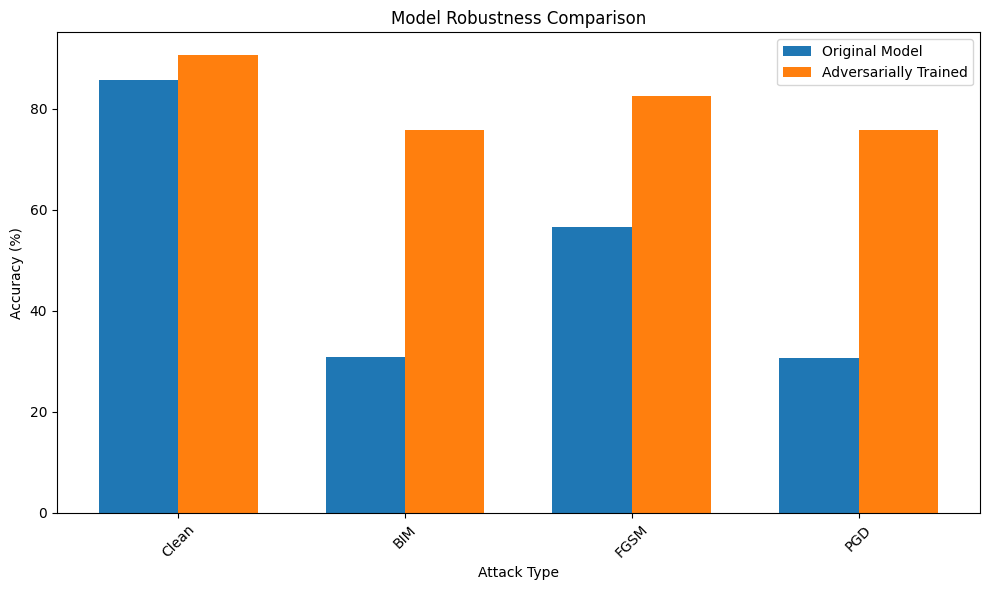

In [4]:
    # Plot comparison
    plt.figure(figsize=(10, 6))

    # Get all unique attack types
    all_attacks = sorted(set(list(original_attack_results.keys()) + list(attack_results.keys())))
    x = np.arange(len(all_attacks) + 1)  # +1 for clean accuracy
    width = 0.35

    # Prepare data for plotting
    original_values = [original_clean_acc]
    adversarial_values = [clean_acc]

    # Add attack accuracies in consistent order
    for attack in all_attacks:
        original_values.append(original_attack_results.get(attack, 0))
        adversarial_values.append(attack_results.get(attack, 0))

    # Create bars
    plt.bar(x - width/2, original_values, width, label='Original Model')
    plt.bar(x + width/2, adversarial_values, width, label='Adversarially Trained')

    plt.xlabel('Attack Type')
    plt.ylabel('Accuracy (%)')
    plt.title('Model Robustness Comparison')
    plt.xticks(x, ['Clean'] + all_attacks)
    plt.legend()

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()